In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use("seaborn")
%matplotlib inline
import time
import glob
import matplotlib
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import torch
import torch.nn as nn
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [56]:
coin_list=['ADA', 'BNB', 'ETH', 'LINK', 'LTC', 'XRP']

In [57]:
df_dict = {}

directory = '../data/final_data' ### directory with final data
all_files = glob.glob(directory + "/*.csv")

for file in all_files:
    
    df = pd.read_csv(file, index_col=None, header=0)
    df_dict[file.split('\\')[1][:-10]] = df

In [58]:
columns = list(df_dict[coin_list[0]].columns)
not_quant = ['Open Time','Close Time', 'bin'] ### take out label and non-quantitative data 
quants = [i for i in columns if i not in not_quant][1:]

In [59]:
def separate(data, break_point=.15, window_length=.05, desired_feature=4):
    
    #separate into training, testing data 
    
    upper=int((1-break_point) * data.shape[0]) + int(window_length * data.shape[0])
    lower=int((1-break_point) * data.shape[0]) - int(window_length * data.shape[0])
    
    train_x, train_y = data[:lower, :, :], data[1:lower+1, -1, desired_feature]
    test_x, test_y = data[upper:-1], data[upper+1:, -1, desired_feature]
    
    return train_x, train_y, test_x, test_y

In [60]:
data=df_dict['ETH']

In [61]:
data.head()

,Unnamed: 0,Open Time,Time of Day,Open,High,Low,Close,Volume,Close Time,Quote asset vol,...,fastd,SAR,ULTOSC,WILLR,AD,ADOSC,OBV,ATR,NATR,Spinning Top
0,174,2017-07-17 19:00:00,68400,0.084001,0.084948,0.083803,0.084401,148.592,2017-07-17 19:29:59.999,12.518292,...,21.861277,0.093699,48.706954,-63.613793,-338.080216,-25.036520,2286.077,0.001426,0.001426,0.0
1,175,2017-07-17 19:30:00,70200,0.084543,0.084806,0.083997,0.084530,138.855,2017-07-17 19:59:59.999,11.721327,...,32.486400,0.093699,47.095021,-60.055172,-293.969295,-10.497259,2424.932,0.001382,0.001382,-1.0
2,176,2017-07-17 20:00:00,72000,0.084527,0.085682,0.084257,0.085385,145.361,2017-07-17 20:29:59.999,12.345477,...,65.819734,0.093699,50.203023,-36.468966,-209.200880,23.376685,2570.293,0.001385,0.001385,0.0
3,177,2017-07-17 20:30:00,73800,0.085632,0.087345,0.085378,0.086139,152.328,2017-07-17 20:59:59.999,13.179450,...,85.743719,0.093699,53.760233,-29.371651,-243.662476,24.144001,2722.621,0.001427,0.001427,0.0
4,178,2017-07-17 21:00:00,75600,0.086357,0.087203,0.086234,0.086626,110.859,2017-07-17 21:29:59.999,9.613967,...,100.000000,0.093699,49.002871,-20.066983,-264.827507,15.528666,2833.480,0.001401,0.001401,0.0


In [62]:
data.columns

Index(['Unnamed: 0', 'Open Time', 'Time of Day', 'Open', 'High', 'Low',
       'Close', 'Volume', 'Close Time', 'Quote asset vol', 'Num trades',
       'Taker buy base asset volume', 'Taker buy quote asset volume', 'Status',
       'bin', 'Close_pct', 'Open_pct', 'High_pct', 'Low_pct', 'SMA', 'EMA',
       'DEMA', 'TEMA', 'KAMA', 'mama', 'fama', 'MIDPOINT', 'MIDPRICE',
       'BB_upper', 'BB_ema', 'BB_lower', 'ADX', 'ADXR', 'AROONOSC', 'BOP',
       'CCI', 'CMO', 'MACD', 'MACD Signal', 'MFI', 'PPO', 'ROC', 'ROCP',
       'ROCR', 'ROCR100', 'RSI', 'fastk', 'fastd', 'SAR', 'ULTOSC', 'WILLR',
       'AD', 'ADOSC', 'OBV', 'ATR', 'NATR', 'Spinning Top'],
      dtype='object')

In [63]:
data['budget_tbm']=0

In [64]:
for i in data.index[:-25]:
    
    for j in range(25):
     
        if data['BB_upper'][i] < data['Close'][i:i+25].values[j] or data['BB_lower'][i] > data['Close'][i]:
            data['budget_tbm'][i] = 1
            break
    
        elif data['BB_lower'][i] > data['Close'][i:i+25].values[j] or data['BB_upper'][i] < data['Close'][i]:
            data['budget_tbm'][i]=-1
            break

E:\Users\Justin\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
E:\Users\Justin\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [65]:
data['budget_tbm'].value_counts()

 1    24724
-1    20736
 0    12745
Name: budget_tbm, dtype: int64

In [66]:
sub_data=data.iloc[:-25]

In [67]:
sub_data.shape

(58180, 58)

In [68]:
x_training=sub_data.iloc[:-6000][quants]
y_training=sub_data.iloc[:-6000]['budget_tbm']

x_testing=sub_data.iloc[-4500:][quants]
y_testing=sub_data.iloc[-4500:]['budget_tbm']

In [69]:
x_training.head()

,Time of Day,Open,High,Low,Close,Volume,Quote asset vol,Num trades,Taker buy base asset volume,Taker buy quote asset volume,...,fastd,SAR,ULTOSC,WILLR,AD,ADOSC,OBV,ATR,NATR,Spinning Top
0,68400,0.084001,0.084948,0.083803,0.084401,148.592,12.518292,189.0,86.206,7.263059,...,21.861277,0.093699,48.706954,-63.613793,-338.080216,-25.036520,2286.077,0.001426,0.001426,0.0
1,70200,0.084543,0.084806,0.083997,0.084530,138.855,11.721327,177.0,85.985,7.259159,...,32.486400,0.093699,47.095021,-60.055172,-293.969295,-10.497259,2424.932,0.001382,0.001382,-1.0
2,72000,0.084527,0.085682,0.084257,0.085385,145.361,12.345477,188.0,89.234,7.579672,...,65.819734,0.093699,50.203023,-36.468966,-209.200880,23.376685,2570.293,0.001385,0.001385,0.0
3,73800,0.085632,0.087345,0.085378,0.086139,152.328,13.179450,172.0,85.237,7.373539,...,85.743719,0.093699,53.760233,-29.371651,-243.662476,24.144001,2722.621,0.001427,0.001427,0.0
4,75600,0.086357,0.087203,0.086234,0.086626,110.859,9.613967,138.0,61.931,5.371950,...,100.000000,0.093699,49.002871,-20.066983,-264.827507,15.528666,2833.480,0.001401,0.001401,0.0


In [70]:
print(x_training.shape)
print(y_training.shape)
print(x_testing.shape)
print(y_testing.shape)

(52180, 53)
(52180,)
(4500, 53)
(4500,)


In [71]:
regressor=LogisticRegression(random_state=0).fit(x_training, y_training)
results=regressor.predict(x_testing)

C:\Users\Justin\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [72]:
confusion_matrix(results, y_testing)

array([[  53,   19,   25],
       [  30,   17,   19],
       [1697,  893, 1747]], dtype=int64)

In [73]:
np.unique(results, return_counts=True)

(array([-1,  0,  1], dtype=int64), array([  97,   66, 4337], dtype=int64))

In [74]:
data['Open Time'].iloc[-4500:].values

array(['2020-08-14 01:00:00', '2020-08-14 01:30:00',
       '2020-08-14 02:00:00', ..., '2020-11-15 17:30:00',
       '2020-11-15 18:00:00', '2020-11-15 18:30:00'], dtype=object)

No handles with labels found to put in legend.


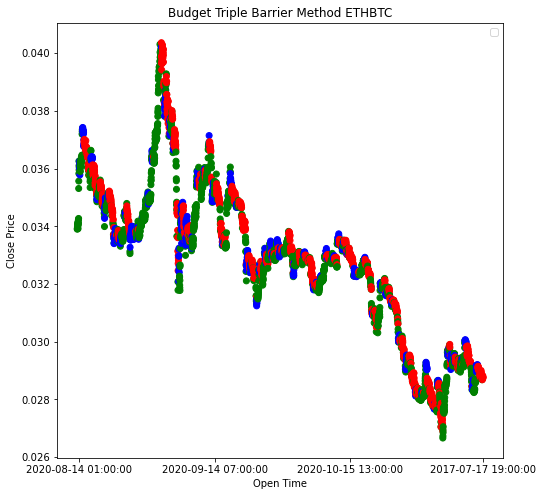

In [75]:
colors=['red', 'blue', 'green']
fig = plt.figure(figsize=(8,8))
plt.scatter(data['Open Time'].values[-4_525:-25], data['Close'].values[-4_525:-25], c=y_testing, cmap=matplotlib.colors.ListedColormap(colors))
#plt.scatter(range(4500), data['Close'].values[-4_525:-25], c=y_testing, cmap=matplotlib.colors.ListedColormap(colors))
plt.title('Budget Triple Barrier Method ETHBTC')
plt.xticks(data['Open Time'].iloc[[-i for i in range(4500, -1, -1500)]])
plt.xlabel('Open Time')
plt.ylabel('Close Price')
plt.legend()

plt.show()


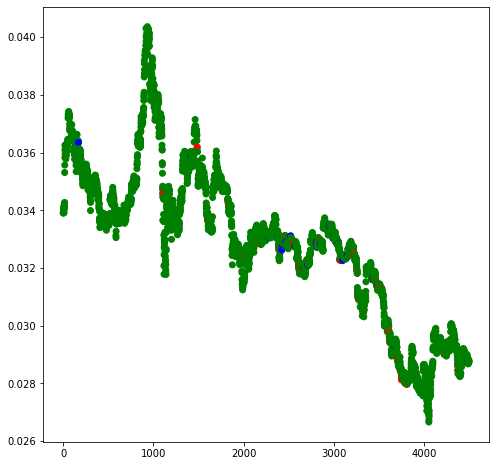

In [76]:
colors=['red', 'blue', 'green']
fig = plt.figure(figsize=(8,8))
plt.scatter(range(4_500), data['Close'].values[-4_525:-25], c=results, cmap=matplotlib.colors.ListedColormap(colors))

In [77]:
primary=RandomForestClassifier(random_state=0).fit(x_training, y_training)

In [78]:
results=primary.predict(x_testing)

In [79]:
confusion_matrix(results, y_testing)

array([[1277,  364,  492],
       [ 175,  297,  177],
       [ 328,  268, 1122]], dtype=int64)

In [80]:
print(classification_report(y_testing, results, labels=[-1, 1, 0]))

              precision    recall  f1-score   support

          -1       0.60      0.72      0.65      1780
           1       0.65      0.63      0.64      1791
           0       0.46      0.32      0.38       929

    accuracy                           0.60      4500
   macro avg       0.57      0.55      0.56      4500
weighted avg       0.59      0.60      0.59      4500



In [81]:
np.unique(results, return_counts=True)

(array([-1,  0,  1], dtype=int64), array([2133,  649, 1718], dtype=int64))

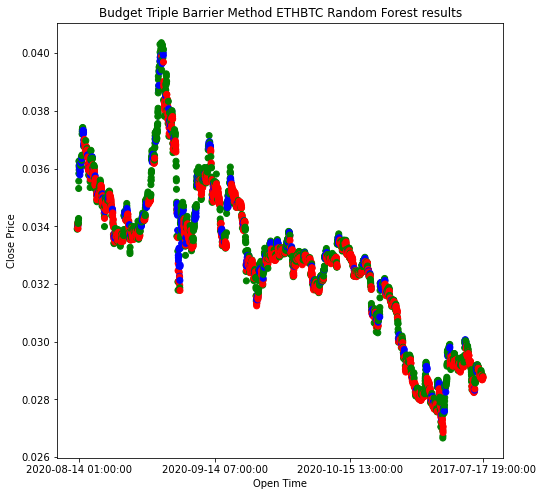

In [82]:
colors=['red', 'blue', 'green']
fig = plt.figure(figsize=(8,8))
plt.scatter(data['Open Time'].values[-4_525:-25], data['Close'].values[-4_525:-25], c=results, cmap=matplotlib.colors.ListedColormap(colors))
#plt.scatter(range(4500), data['Close'].values[-4_525:-25], c=y_testing, cmap=matplotlib.colors.ListedColormap(colors))
plt.title('Budget Triple Barrier Method ETHBTC Random Forest results')
plt.xticks(data['Open Time'].iloc[[-i for i in range(4500, -1, -1500)]])
plt.xlabel('Open Time')
plt.ylabel('Close Price')

plt.show()

In [83]:
mlp=MLPClassifier(random_state=0, max_iter=300).fit(x_training, y_training)
results=mlp.predict(x_testing)

In [84]:
confusion_matrix(results, y_testing)

array([[   0,    0,    0],
       [   0,    0,    0],
       [1780,  929, 1791]], dtype=int64)

In [85]:
np.unique(results, return_counts=True)

(array([1], dtype=int64), array([4500], dtype=int64))

In [86]:
neigh=KNeighborsClassifier(n_neighbors=50).fit(x_training, y_training)
neigh.predict(x_testing)

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [87]:
confusion_matrix(results, y_testing)

array([[   0,    0,    0],
       [   0,    0,    0],
       [1780,  929, 1791]], dtype=int64)

In [88]:
bayes=GaussianNB().fit(x_training, y_training)

In [89]:
results=bayes.predict(x_testing)

In [90]:
confusion_matrix(results, y_testing)

array([[1253,  429,  673],
       [ 187,  193,  289],
       [ 340,  307,  829]], dtype=int64)

In [91]:
np.unique(results, return_counts=True)

(array([-1,  0,  1], dtype=int64), array([2355,  669, 1476], dtype=int64))

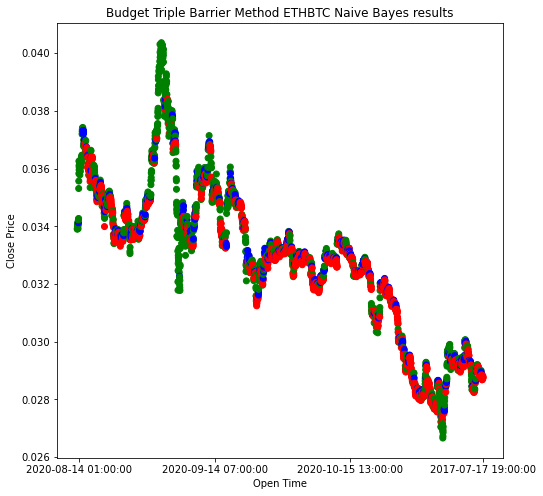

In [92]:
colors=['red', 'blue', 'green']
fig = plt.figure(figsize=(8,8))
plt.scatter(data['Open Time'].values[-4_525:-25], data['Close'].values[-4_525:-25], c=results, cmap=matplotlib.colors.ListedColormap(colors))
#plt.scatter(range(4500), data['Close'].values[-4_525:-25], c=y_testing, cmap=matplotlib.colors.ListedColormap(colors))
plt.title('Budget Triple Barrier Method ETHBTC Naive Bayes results')
plt.xticks(data['Open Time'].iloc[[-i for i in range(4500, -1, -1500)]])
plt.xlabel('Open Time')
plt.ylabel('Close Price')

plt.show()

In [93]:
mllabels=data['bin']

In [94]:
buy_labels=np.where(mllabels==1)
sell_labels=np.where(mllabels==-1)
hold_labels=np.where(mllabels==0)

In [95]:
sub_df=data.iloc[buy_labels]

In [96]:
sub_df=sub_df.append(data.iloc[sell_labels])
sub_df=sub_df.append(data.iloc[hold_labels])

In [97]:
X=sub_df[quants].values

In [98]:
y=sub_df['bin'].values

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [100]:
X_train.shape

(3855, 53)

In [101]:
X_test.shape

(964, 53)

In [102]:
secondary=RandomForestClassifier(random_state=0).fit(X_train, y_train)

In [103]:
results=secondary.predict(X_test)

In [104]:
np.unique(results, return_counts=True)

(array([-1.,  0.,  1.]), array([457,  17, 490], dtype=int64))

In [105]:
confusion_matrix(results, y_test)

array([[282,  40, 135],
       [  2,  12,   3],
       [131,  48, 311]], dtype=int64)

In [106]:
prob=secondary.predict_proba(X_test)

In [107]:
prob

array([[0.3 , 0.42, 0.28],
       [0.59, 0.06, 0.35],
       [0.33, 0.15, 0.52],
       ...,
       [0.41, 0.07, 0.52],
       [0.51, 0.12, 0.37],
       [0.45, 0.12, 0.43]])

In [108]:
count=0
labels=[-1, 0, 1]
alt_results=[]
for i in prob:
    mid=np.max(i)-np.min(i)
    if np.max(i)-mid < .15:
        #print(np.max(i))
        alt_results.append(0)
    else:
        alt_results.append(labels[np.argmax(i)])
np.unique(np.array(alt_results), return_counts=True)

(array([-1,  0,  1]), array([ 74, 801,  89], dtype=int64))

In [110]:
results=secondary.predict_proba(data[quants].values[-4_525:-25])

In [111]:
count=0
labels=[-1, 0, 1]
alt_results=[]
for i in results:
    mid=np.max(i)-np.min(i)
    if np.max(i)-mid < .3:
        #print(np.max(i))
        alt_results.append(0)
    else:
        alt_results.append(labels[np.argmax(i)])
np.unique(np.array(alt_results), return_counts=True)

(array([-1,  0,  1]), array([ 258, 4094,  148], dtype=int64))

In [112]:
buy_points=np.where(np.array(alt_results)==1)
sell_points=np.where(np.array(alt_results)==-1)

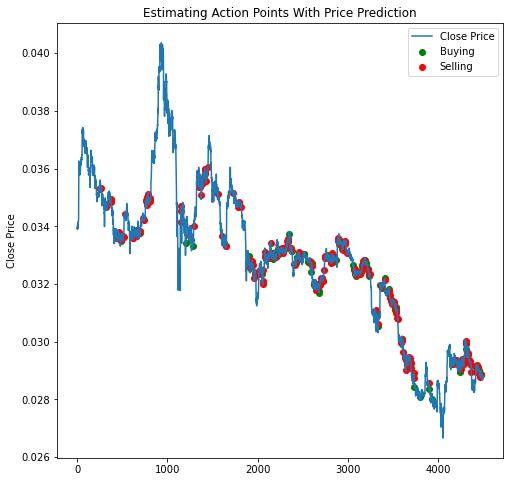

In [113]:
fig = plt.figure(figsize=(8,8))
plt.plot(range(4500), data['Close'].values[-4_525:-25], label='Close Price')
plt.scatter(buy_points, np.array(data['Close'].values[-4_525:-25])[buy_points], color='green', label='Buying')
plt.scatter(sell_points, np.array(data['Close'].values[-4_525:-25])[sell_points], color='red', label='Selling')
plt.title('Estimating Action Points With Price Prediction')
plt.legend()
plt.ylabel('Close Price')

plt.show()

In [114]:
##use lstm to find better point
##use primary model to determine the label 
##use secondary to determine volume

In [115]:
from joblib import dump, load

In [116]:
dump(primary, 'primary_model.joblib') 
dump(secondary, 'secondary_model.joblib') 

['secondary_model.joblib']